Diabetic Retinopathy Classifier

This jupyter notebook demonstrate the application of DenseNet121 to classify diabetic retinopathy 
fundus images.

__author__ = "Jianfei Liu"

__copyright__ = "Copyright 2023, Diabetic Retinopathy Project"

__credits__ = ["Jianfei Liu"]

__license__ = "GPL"

__version__ = "1.0"

__maintainer__ = "Jianfei Liu"

__email__ = "jianfei.liu@nih.gov"

__status__ = "Development"


# DenseNet-121 Diabetic Retinopathy Classifier

### Introduction

The Kaggle Diabetic Retinopathy (DR) dataset [1] is a color fundus image database. This database was provided by EyePACS, and fundus images were caputured under various conditions by differrent devices at multiple primary care sites. For each subject, two images of the left and left eyes were collected. A clinician was asked to rate each image for the presence of DR with a scale of 0–4 according to the Early Treatment Diabetic Retinopathy Study (ETDRS) scale. The downloading link [1] only contains 35,126 images that were originally used as the training dataset. In this task, I will rearrage these images, and split them into training, validation, and testing data. 

The purpose of this task is to develop a classifer to automatically decide the scale of the presence of DR for a fundus image, similar to what the clinician did. The DenseNet is used to serve this purpose because it achieves the high claissficiation accuracy with a resonable computational cost. 

### Network Architecture

The network in this notebook is an implementation of the DenseNet-121 [1] architecture to train a retinopathy classifier. It classifies the input fundus image into the presence of diabetic retinopathy with a scale of 0–4. 

The pipeline of the DenseNet is illustrated in below. In each "dense" block, each layer is connected with each previous layer -- the feature maps are concatenated.

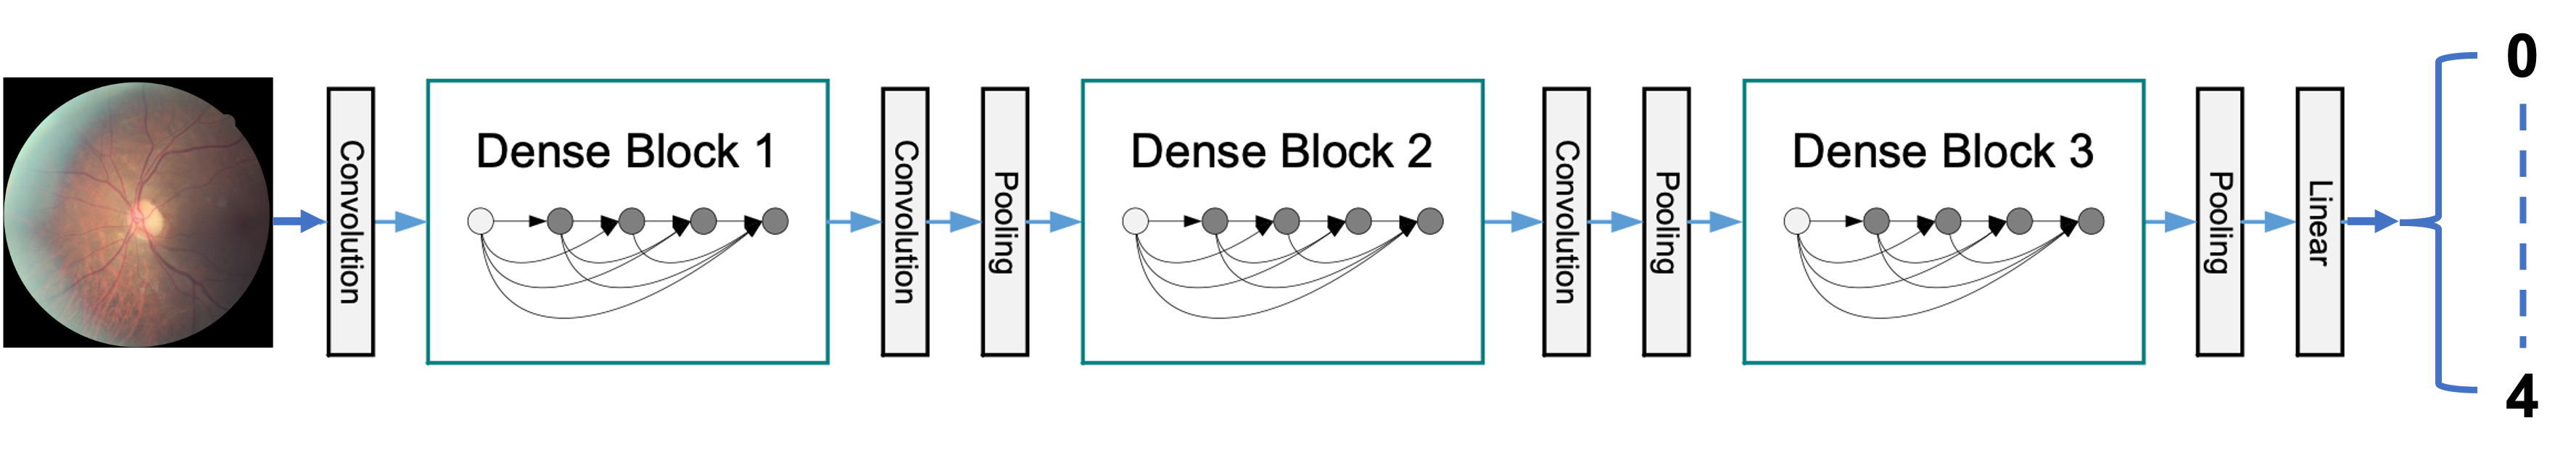
Figure 1: A deep DenseNet with three dense blocks. The layers between two adjacent blocks are referred to as transition layers and change feature-map sizes via convolution and pooling (modified from Fig. 2 in [1]).

Let $H_l(\cdot)$ be a composite function of operations sucha as Batch Normalization (BN), rectified linear units (ReLU), Pooling, or Convolution (Conv). We denote the output of the $l^{th}$ layer of $\mathbf{x}_l$. In DenseNets, all previous feature maps $\mathbf{x}_0, \ldots, \mathbf{x}_{l-1}$ of a feature map $\mathbf{x}_l$ are concatenated.
$$\mathbf{x}_l = H_l(\mathbf{x}_0, \mathbf{x}_1, \ldots, \mathbf{x}_{l-1})$$
There are multiple types of DenseNets in the original paper [1], and the DenseNet-121 is used in this work for its least computational cost. 

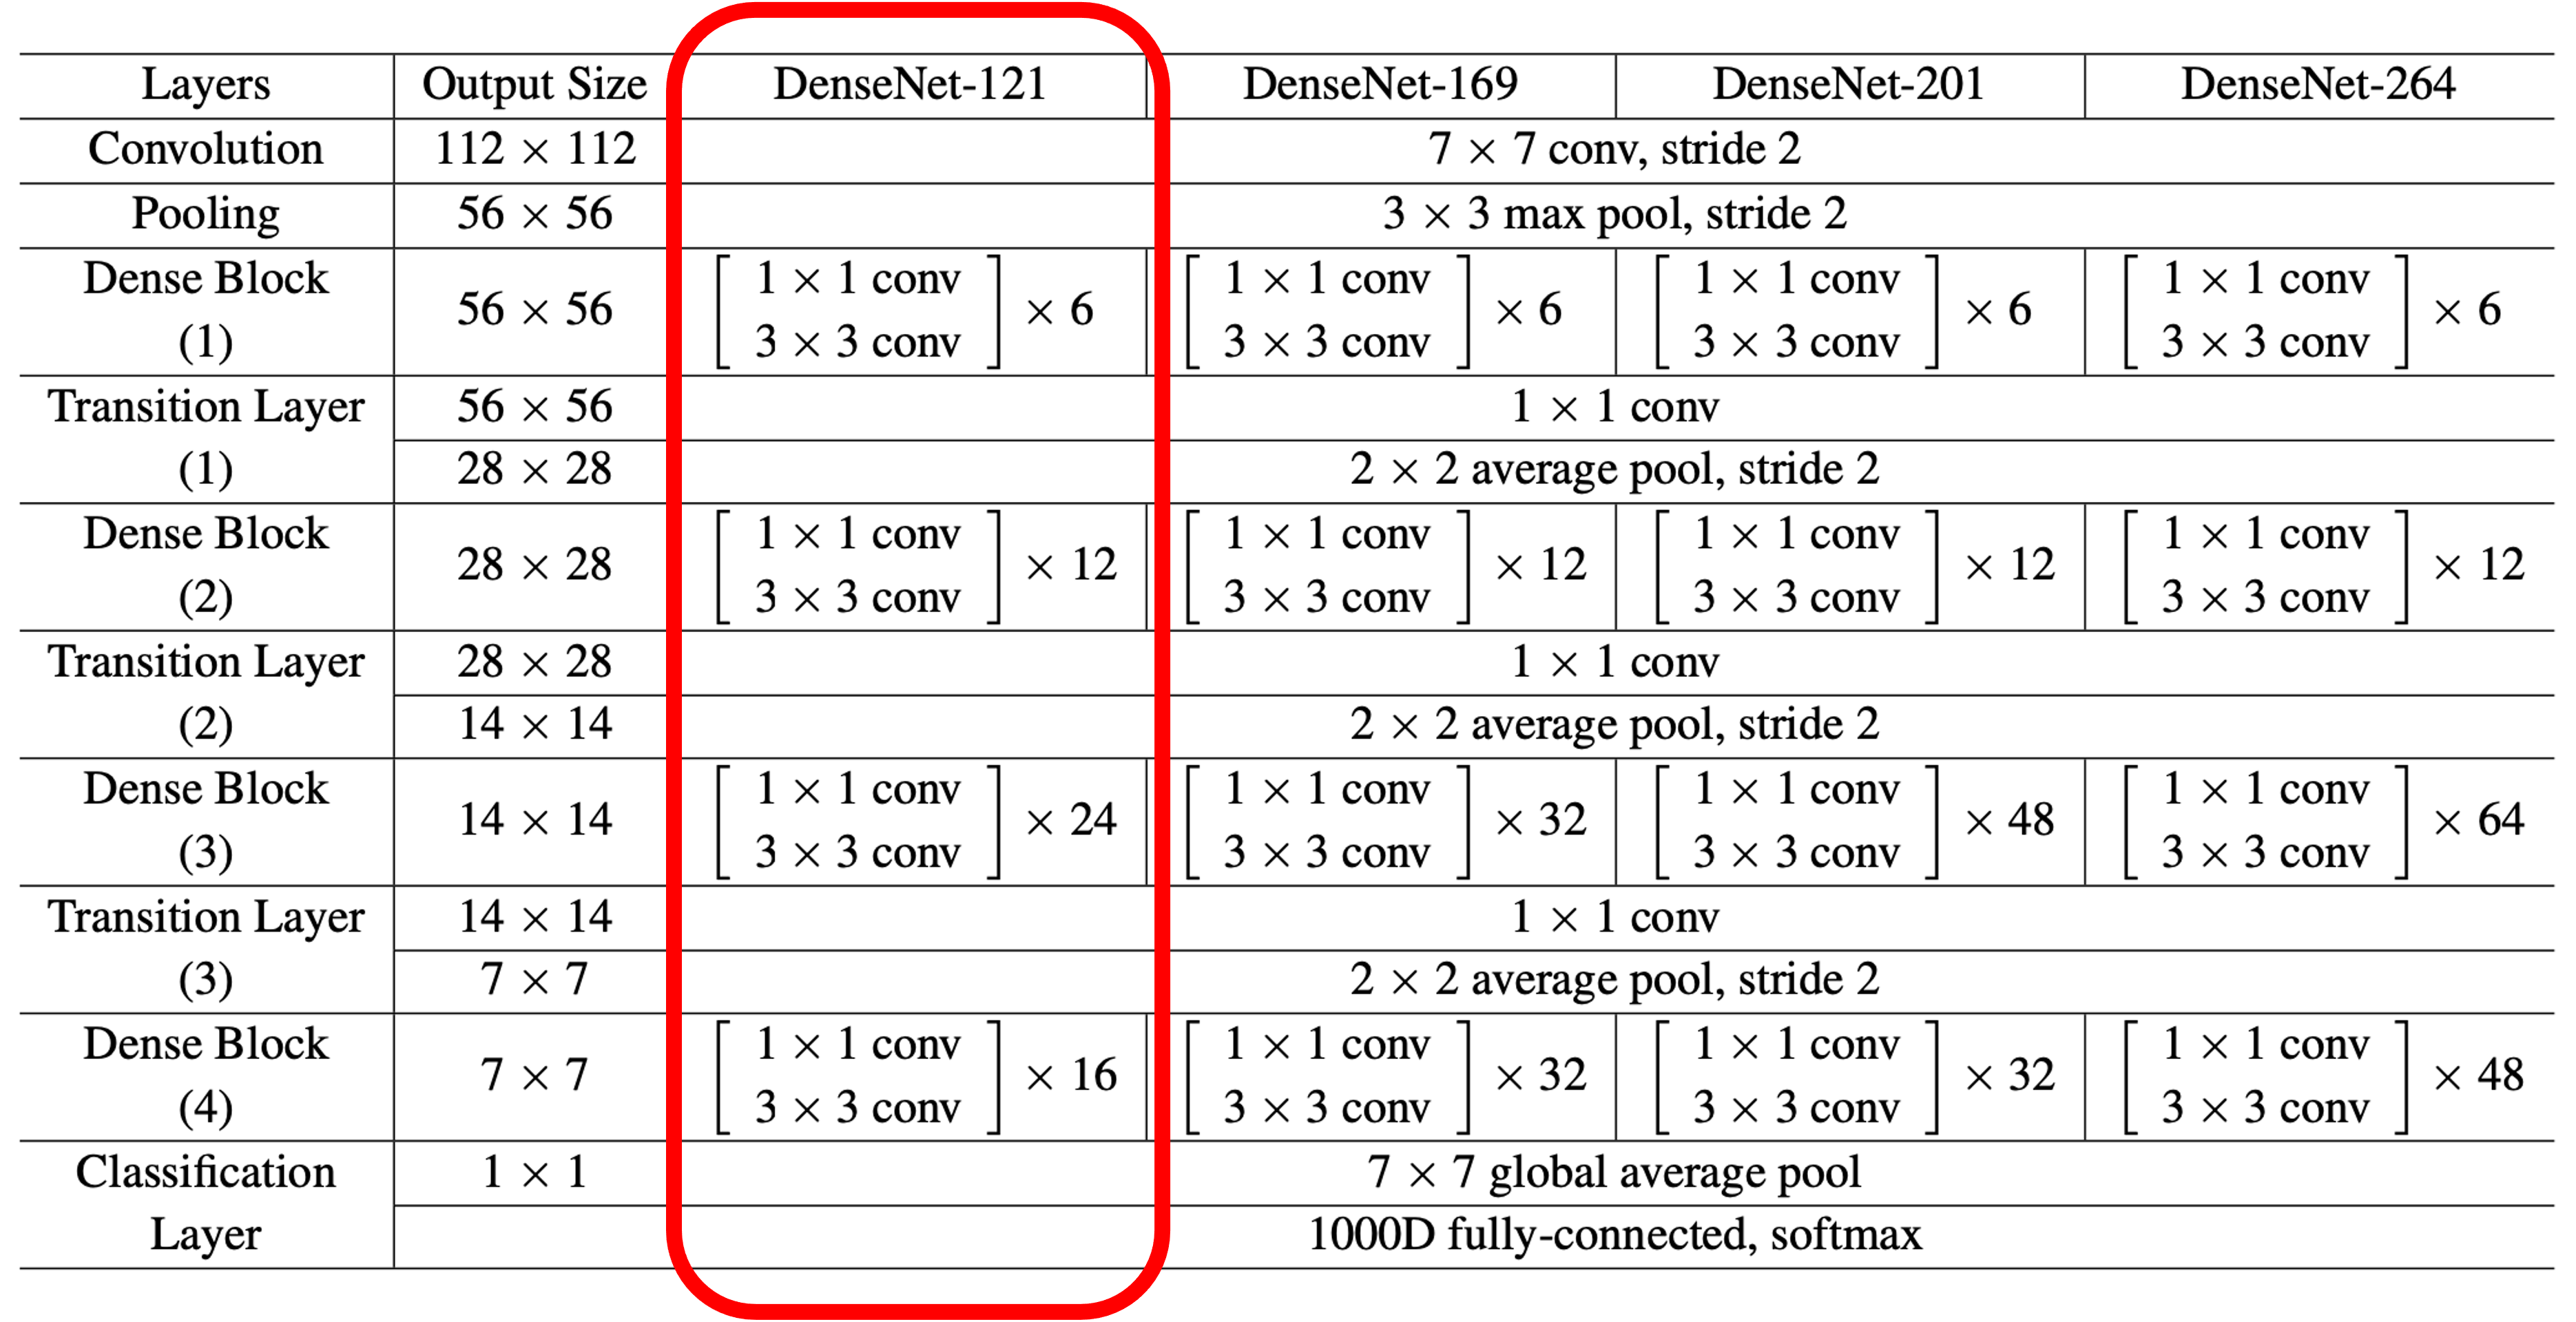
Table 1: DenseNet architectures for ImageNet. The growth rate for all the networks is k = 32. Note that each “conv” layer shown in the table corresponds the sequence BN-ReLU-Conv. In this work, the DenseNet-121 is used. 

#### Reference

[1] Kaggle Diabetic Retinopathy dataset. https://www.kaggle.com/datasets/mariaherrerot/eyepacspreprocess

[2] G. Huang, Z. Liu, L. Van Der Maaten, and K. Q. Weinberger. Densely Connected Convolutional Networks. In IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2017. https://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html

### Imports

In [ ]:
import os
import time

import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image

from typing import Any, Dict, Iterator, List, Optional, Tuple

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from pathlib import Path


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

### Model Settings

In [ ]:
##########################
### SETTINGS
##########################

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0001
BATCH_SIZE = 8
NUM_EPOCHS = 50

# Data set
IMAGE_SIZE = 256

# Architecture
NUM_CLASSES = 5

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Diabetic Retinopathy Dataset

#### Dataset Exploration

DR dataset is put in the same fold as the "DR-classification.ipynb" file.
The directory structure of DR dataset is formulated as

dataset/ 

         ├── trainLabels.csv
         │   
         └── eyepacs_preprocess
                ├── 10_left.jpeg
                ├── 10_right.jpeg
                └── ...
                └── 44349_right.jpeg


In [ ]:
##display the first 6 records in the label file
df=pd.read_csv('dataset/trainLabels.csv')
df.head(6)

In [ ]:
##get the number of image labels
df.shape

In [ ]:
##Calculate the statistics of image labels
df.describe()

In [ ]:
##get the set of unique image labels
df.level.unique()

In [ ]:
# check if DR levels are balanced..
df.level.plot(kind='hist', title='histogram of diabetic retinopathy levels', 
        rot=45, figsize=(6,3), fontsize=10, legend=False)
plt.xlabel('Diabetic retinopathy level')
plt.ylabel('Number of image labels')

In [ ]:
# print out the number of labels of each level
df.level.value_counts()

In [ ]:
##check if the number of DR levels is matched with the number of input funduse images
fundus_img_filenames=[f for f in os.listdir('dataset/eyepacs_preprocess') if f.endswith('.jpeg')]
print(len(fundus_img_filenames))

In [ ]:
# Since the numbers of fundus images and labels are matched, now we can now safly and randomly display 50 
# Randomly search for 10 image file names per level
# Read images and display them
# f, axarr = plt.subplots(10, 5)
# for ax in axarr:
#     ax.set_axis_off()

fig = plt.figure(figsize=(10, 10))
df_indices = df.index
for level in range(5):
    #get the indices of series elements equal to level
    cur_indices = df['level'] == level
    res_indices = df_indices[cur_indices]
    
    #randomly select 10 indices from the res_indices
    selected_indices = random.choices(res_indices, k=10)
    for i, id in enumerate(selected_indices):
        img_path = os.path.join('dataset/eyepacs_preprocess', df.image[id] + '.jpeg')
        img = Image.open(img_path) 
        imgarr = np.array(img) 
        
        # we set "level+i*5+1" to index subplot to make sure 10 images of 
        # each column corrresponding to one level of diabetic retinopathy.
        # Note the addtion of "1" in "level+i*5+1" because "add_subplot" starts with 1
        fig.add_subplot(10, 5, level+i*5+1)
        plt.imshow(imgarr)
        plt.axis('off')
        
        # Add the level number on top of each column
        if i == 0:
            plt.title('level=' + str(level))

#### Dataset Selection (Training/Validation/Test)

In [ ]:
# Stratified shuffle split is chosen to split data due to class imbalance
from sklearn.model_selection import StratifiedShuffleSplit

# first split the whole data set into train_validation data and test data
X=df.image
Y=df.level
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_val_index, test_index = next(sss.split(X, Y))

# get lists of test image names and labels first
test_image_names=df.image[test_index]
test_labels = df.level[test_index]


# second split train_validation data into training data and test data
X= df.image[train_val_index]
Y=df.level[train_val_index]
train_index, val_index = next(sss.split(X, Y))

train_image_names = df.image[train_index]
train_labels = df.level[train_index]

val_image_names = df.image[val_index]
val_labels = df.level[val_index]

print(train_image_names)
print(val_image_names)
print(test_image_names)

#### Dataset Definition

In [ ]:
class DRDataset(torch.utils.data.Dataset):
    """`Diabetic Retinopathy Classification Dataset.
    Args:
        root (string): Root directory of the Image Dataset.
        image_names (list): The list of image file names used used for DRDataset.
            These image files should also under root directory.
        image_labels (list): Corresponding list of image labels. 
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
     Return:
        (sample, target) (tuples) where target is class_index of the target class
    """

    def __init__(self, root: str, image_names: list, image_labels: list, 
                 transform = None) -> None:
        self.root = root
        
        if type(image_names) == list:
            self.image_names = image_names
        else:
            raise TypeError('The datatype of image_names is {}, not list'.format(type(image_names)))
            
        if type(image_labels) == list:
            self.image_labels = image_labels
        else:
            raise TypeError('The datatype of image_labels is {}, not list'.format(type(image_names)))
            
        self.transform = transform

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        img_path = os.path.join(self.root, self.image_names[index] + '.jpeg')
        image = Image.open(img_path)
        label = self.image_labels[index]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, self.image_names[index]


    def __len__(self) -> int:
        return len(self.image_labels)

#### Dataset Setup (Training/Validation/Test )

In [ ]:
# visualization function to check if training or validation loader can properly yield a batch of data
def visualize_batch(batch, dataset_type):
    # initialize a figure
    fig = plt.figure("{} batch".format(dataset_type),
                     figsize=(BATCH_SIZE, BATCH_SIZE/2))
    
    # loop over the batch size
    for i in range(0, BATCH_SIZE):
        # create a subplot
        ax = plt.subplot(2, 4, i + 1)
        
        # grab the image, convert it from channels first ordering to
        # channels last ordering, and scale the raw pixel intensities
        # to the range [0, 255]
        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        
        # grab the label id and get the label from the classes list
        label = batch[1][i]
        plt.imshow(image)
        plt.title('level=' + str(label) + ", \n" + batch[2][i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

In [ ]:
# define data augmentation

resize = transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE))
hFlip = transforms.RandomHorizontalFlip(p=0.25)
vFlip = transforms.RandomVerticalFlip(p=0.25)
rotate = transforms.RandomRotation(degrees=15)

train_transform = transforms.Compose([resize, hFlip, vFlip, rotate,
                                      transforms.ToTensor()])
valid_transform = transforms.Compose([resize, transforms.ToTensor()])

# define training, validation, and test dataset
train_dataset = DRDataset(root='dataset/eyepacs_preprocess', 
                          image_names=train_image_names.tolist(),
                          image_labels=train_labels.tolist(),
                          transform=train_transform)
valid_dataset = DRDataset(root='dataset/eyepacs_preprocess', 
                          image_names=val_image_names.tolist(),
                          image_labels=val_labels.tolist(),
                          transform=valid_transform)
test_dataset = DRDataset(root='dataset/eyepacs_preprocess', 
                         image_names=test_image_names.tolist(),
                         image_labels=test_labels.tolist(),
                         transform=valid_transform)

# define data loader
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=0,
                         shuffle=False)

print('training batch images')
train_batch = next(iter(train_loader))
visualize_batch(train_batch, 'training')
print('============================================================')
print('============================================================')

print('\n\n\n')
print('validation batch images')
valid_batch = next(iter(valid_loader))
visualize_batch(valid_batch, 'validation')
print('============================================================')
print('============================================================')

print('\n\n\n')
print('testing batch images')
test_batch = next(iter(test_loader))
visualize_batch(test_batch, 'testing')
print('============================================================')
print('============================================================')

### DenseNet Implementation

In [ ]:
class DensNet(nn.Module):
    def __init__(self, num_classes=5, num_channels=3, weights=None):
        super().__init__()
        preloaded = torchvision.models.densenet121(weights=weights)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        logits = self.classifier(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

### Training

#### Training setup

In [ ]:
torch.manual_seed(RANDOM_SEED)
classes = 5
model = DensNet(num_classes=classes)
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# define a weighted loss function since training labels are imbalanced
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(train_labels), 
                                     y=train_labels)
# convert class_weights to tensor
class_weights = torch.from_numpy(class_weights).float()
print(class_weights)

In [ ]:
# for unknown reason, this function is not working..

# def compute_acc(model, data_loader, device):
#     correct_pred, num_examples = 0, 0
#     for i, (images, labels, paths) in enumerate(data_loader):
            
#         images = images.to(device)
#         labels = labels.to(device)

#         logits, probas = model(images)
#         _, predicted_labels = torch.max(probas, 1)
#         num_examples += labels.size(0)
#         assert predicted_labels.size() == labels.size()
#         correct_pred += (predicted_labels == labels).sum()
        
#         if not batch_idx % 10:
#             print (f'Batch {i:03d}/{len(data_loader):03d} | acc: {correct_pred.float()/num_examples * 100:.2f}')
            
#     return correct_pred.float()/num_examples * 100


start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []
best_valid_acc = 0
print('Device: {}'.format(DEVICE) )
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (images, labels, paths) in enumerate(train_loader):
        
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(images)
        cost = F.cross_entropy(logits, labels, class_weights.to(DEVICE))
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        #################################################
        ### CODE ONLY FOR LOGGING BEYOND THIS POINT
        ################################################
        cost_list.append(cost.item())
        if not batch_idx % 10:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        
        #training acc
        correct_pred, num_examples = 0, 0
        for i, (images, labels, paths) in enumerate(train_loader):
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits, probas = model(images)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += labels.size(0)
            assert predicted_labels.size() == labels.size()
            correct_pred += (predicted_labels == labels).sum()
            cur_train_acc = correct_pred.float()/num_examples * 100
            print (f'Batch {i:03d}/{len(train_loader):03d} | Training ACC: {cur_train_acc:.2f}')
            
        train_acc = correct_pred.float()/num_examples * 100
        train_acc_list.append(train_acc.detach().cpu().numpy())
        
        #validation acc         
        correct_pred, num_examples = 0, 0
        for i, (images, labels, paths) in enumerate(valid_loader):
            
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits, probas = model(images)
            _, predicted_labels = torch.max(probas, 1)
            num_examples += labels.size(0)
            assert predicted_labels.size() == labels.size()
            correct_pred += (predicted_labels == labels).sum()
            cur_valid_acc = correct_pred.float()/num_examples * 100
            print (f'Batch {i:03d}/{len(valid_loader):03d} | Validation ACC: {cur_valid_acc:.2f}')
            
        valid_acc = correct_pred.float()/num_examples * 100
        valid_acc_list.append(valid_acc.detach().cpu().numpy())
        
        # always save the model weights with the best          
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            print(best_valid_acc)
            Path("weights").mkdir(parents=True, exist_ok=True)
            model_file_name = os.path.join('weights', 'DRClassifcation.pth')
            
            torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'best_acc': best_valid_acc}, 
                       model_file_name)
            
        
#         train_acc = compute_acc(model, train_loader, device=DEVICE)
#         valid_acc = compute_acc(model, valid_loader, device=DEVICE)

        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

### Evaluation

#### Lost plot

In [ ]:
# Training lost plot
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

#### Accuracy plot

In [ ]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Confusion matrix

In [ ]:
def classify_DR_images(model, data_loader, data_type, device):

    res_label_arr = []
    res_score_arr = []
    for i, (images, labels, paths) in enumerate(data_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        logits, probas = model(images)
        _, predicted_labels = torch.max(probas, 1)
        res_label_arr.append(predicted_labels.detach().cpu().numpy())
        res_score_arr.append(probas.detach().cpu().numpy())
        if i % 50 == 0:
            print (f'Batch {i:03d}/{len(data_loader):03d} | data type: {data_type}')
        
    res_label_arr = np.concatenate(res_label_arr)
    res_score_arr = np.concatenate(res_score_arr)
    return res_label_arr, res_score_arr

In [ ]:
# confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4])
    disp.plot()
    plt.show()

In [ ]:
# if mode file existed, load new model
model_file_name = os.path.join('weights', 'DRClassifcation.pth')
if not os.path.exists(model_file_name) or not os.path.isfile(model_file_name):
    print("=> loading check point {model_file_name}")
    checkpoint = torch.load(model_file_name, map_location = torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'])
    

# confusion matrix of training results 
y_true_train = train_labels.tolist()
y_pred_train, y_prob_train = classify_DR_images(model, train_loader, 'train', DEVICE)
display_confusion_matrix(y_true_train, y_pred_train)

# confusion matrix of validation results 
y_true_val = val_labels.tolist()
y_pred_val, y_prob_val = classify_DR_images(model, valid_loader, 'valiation', DEVICE)
display_confusion_matrix(y_true_val, y_pred_val)


# confusion matrix of testing results 
y_true_test = test_labels.tolist()
y_pred_test, y_prob_test = classify_DR_images(model, test_loader, 'test', DEVICE)
display_confusion_matrix(y_true_test, y_pred_test)

#### One-vs-Rest ROC Curves

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

def display_roc_one_vs_rest(y_true, y_score, display_name):
    fig, ax = plt.subplots(figsize=(6, 6))
    
    label_binarizer = LabelBinarizer().fit([0,1,2,3,4])
    y_onehot_true = label_binarizer.transform(y_true)
    
    colors = cycle(["aqua", "darkorange", "cornflowerblue", "deeppink", "navy"])
    
    for class_id, color in zip(range(5), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_true[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {class_id:01d}",
            color=color,
            ax=ax,
        )

    plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'Receiver Operating Characteristic\nto One-vs-Rest multiclass for {display_name}')
    plt.legend()
    plt.show()

In [ ]:
# display ROC curves for training data
display_roc_one_vs_rest(y_true_train, y_prob_train, 'training')

# display ROC curves for validation data
display_roc_one_vs_rest(y_true_val, y_prob_val, 'validation')

# display ROC curves for test data
display_roc_one_vs_rest(y_true_test, y_prob_test, 'testing')

### Summary

* In this work, I demonstrated the usage of DenseNet to classify the level of diabetic retinopathy fundus images.
* The main challenge of this task was the imbalance among four different levels of fundus images, and the weighted cross entropy loss function was utilized to address this issue. 
* Due to lack of computational resource, ROC curves have not reached the best performance (Epochs = 5 in this work). However, the accuracy is continuously increasing during training.
* DenseNet was trained from scratch, and the pretrained ImageNet model weight was not used to initialize DenseNet. This could be included in the future work.